# Analisi i predicció dels accidents de transit a Barcelona

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
import folium
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek 
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM
from keras import optimizers



Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving 2016_accidents_vehicles_gu_bcn_.csv to 2016_accidents_vehicles_gu_bcn_.csv
Saving 2017_accidents_vehicles_gu_bcn_.csv to 2017_accidents_vehicles_gu_bcn_.csv
Saving 2018_accidents_vehicles_gu_bcn_.csv to 2018_accidents_vehicles_gu_bcn_.csv


# Dataset de les Vehicles accidentats

In [3]:
import io
accidents_vehicles2016 = pd.read_csv(io.BytesIO(uploaded['2016_accidents_vehicles_gu_bcn_.csv']))
accidents_vehicles2017 = pd.read_csv(io.BytesIO(uploaded['2017_accidents_vehicles_gu_bcn_.csv']))
accidents_vehicles2018 = pd.read_csv(io.BytesIO(uploaded['2018_accidents_vehicles_gu_bcn_.csv']))

accidents_vehicles2018.drop(['Descripcio_torn'], axis=1, inplace=True)

### Mirem quina forma té el dataset
print('DataSet Persones - Nombre instances: {}, number of Training attributes: {}'.format(accidents_vehicles2016.shape[0], accidents_vehicles2016.shape[1]))
print('DataSet Persones - Nombre instances: {}, number of Training attributes: {}'.format(accidents_vehicles2017.shape[0], accidents_vehicles2017.shape[1]))
print('DataSet Persones - Nombre instances: {}, number of Training attributes: {}'.format(accidents_vehicles2018.shape[0], accidents_vehicles2018.shape[1]))


accidents_vehicles2016.rename(columns={' Longitud':'Longitud'}, inplace=True)
accidents_vehicles2016.rename(columns={' Latitud':'Latitud'}, inplace=True)

accidents_vehicles = pd.concat([accidents_vehicles2016, accidents_vehicles2017, accidents_vehicles2018],ignore_index=True)
print('DataSet Persones - Nombre instances: {}, number of Training attributes: {}'.format(accidents_vehicles.shape[0], accidents_vehicles.shape[1]))

num_columns = len(accidents_vehicles.columns)
pd.set_option("display.max_columns", num_columns)

# accidents_vehicles2018['Descripcio_causa_vianant'].unique()

DataSet Persones - Nombre instances: 19410, number of Training attributes: 27
DataSet Persones - Nombre instances: 19795, number of Training attributes: 27
DataSet Persones - Nombre instances: 19079, number of Training attributes: 27
DataSet Persones - Nombre instances: 58284, number of Training attributes: 28


In [0]:
### Fem neteja dels atributs, eliminant dades incorrectes.
accidents_vehicles = accidents_vehicles[accidents_vehicles['Codi_districte'] > 0] #Eliminem els districtes -1
accidents_vehicles = accidents_vehicles[accidents_vehicles['Codi_carrer'] > 0] #Eliminem els districtes -1


### Alguns agents de Guardia Urbana posaven Turismo i els altres Turisme... Ho hem passat tot a Turisme.
accidents_vehicles = accidents_vehicles.replace({'Turismo': 'Turisme'}, regex=True)

### Seleccionar atributs d'especial interés per l'anàlisi.
atributs_selecionats = ['Codi_barri','Codi_carrer','Codi_districte','Descripcio_color','Descripcio_marca',
                        'Descripcio_model','Descripcio_tipus_dia','Descripcio_dia_setmana','Descripcio_tipus_vehicle','Antiguitat_carnet','Dia_mes',
                        'Hora_dia','Mes_any','NK_Any','Latitud','Longitud']
accidents_vehicles = accidents_vehicles[atributs_selecionats]

accidents_vehicles = accidents_vehicles[accidents_vehicles['Descripcio_tipus_vehicle']=='Turisme']


In [5]:
accidents_vehicles = accidents_vehicles.replace({'A.U.D.I.': 'AUDI'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'A U D I': 'AUDI'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'MERCEDES-BENZ': 'MERCEDES'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'MECEDES': 'MERCEDES'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'MERCEDES B': 'MERCEDES'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'B.M.W.': 'BMW'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'B M W': 'BMW'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'MICROCAR': 'SMART'}, regex=True)
accidents_vehicles = accidents_vehicles.replace({'JAGUAR LAND ROV': 'LAND ROVER'}, regex=True)


accidents_vehicles['Descripcio_marca'].unique()

array(['AUDI', 'LEXUS', 'SMART', 'RENAULT', 'HONDA', 'SEAT', 'MITSUBISHI',
       'OPEL', 'VOLVO', 'TOYOTA', 'PEUGEOT', 'MAZDA', 'Desconegut',
       'MERCEDES', 'NISSAN', 'FIAT', 'HYUNDAI', 'VOLKSWAGEN', 'CITROEN',
       'FORD', 'LAND ROVER', 'KIA', 'SAAB', 'ALFA ROMEO', 'MINI', 'BMW',
       'DACIA', 'LANCIA', 'CHEVROLET', 'JAGUAR', 'TATA', 'DAEWOO',
       'SUZUKI', 'SKODA', 'CHRYSLER', 'SUBARU', 'JEEP', 'SSANGYONG', 'MG',
       'ROVER', 'PORSCHE', 'MAN', 'DODGE', 'SETRA', 'PIAGGIO', 'MASERATI',
       'BYD', 'FERRARI', 'MAHINDRA', 'DAIMLER', 'INFINITI', 'CADILLAC',
       'YAMAHA', 'GALLOPER', 'HUMMER', 'ES DESCONEIX', 'IVECO FIAT',
       'SYM', 'ASTON MARTIN', 'TRIGGER', 'KEEWAY', 'KYMCO', 'DAIHATSU',
       'ROLLS-ROYCE', 'IRISBUS', 'LEONART', 'BERGADANA', 'S.Y.M',
       'APRILIA', 'IVECO BUS', 'LINCOLN', 'TECNUVE'], dtype=object)

In [6]:
accidents_vehicles2_not = accidents_vehicles[accidents_vehicles['Descripcio_model']=='Desconegut']
accidents_vehicles2_not = accidents_vehicles[accidents_vehicles['Descripcio_model']=='ES DESCONEIX']

accidents_vehicles2 = accidents_vehicles[accidents_vehicles['Descripcio_model']!='Desconegut']
accidents_vehicles3 = accidents_vehicles2[accidents_vehicles2['Descripcio_model']!='ES DESCONEIX']
accidents_vehicles3 = accidents_vehicles3[accidents_vehicles3['Antiguitat_carnet']!='Desconegut']
accidents_vehicles3 = accidents_vehicles3[accidents_vehicles3['Descripcio_color']!='Desconegut']
accidents_vehicles3 = accidents_vehicles3[accidents_vehicles3['Descripcio_marca']!='Desconegut']
accidents_vehicles3 = accidents_vehicles3[accidents_vehicles3['Descripcio_model']!=' ']
 
accidents_vehicles3['Descripcio_marca'].unique()

array(['AUDI', 'LEXUS', 'SMART', 'RENAULT', 'HONDA', 'SEAT', 'OPEL',
       'VOLVO', 'TOYOTA', 'PEUGEOT', 'MERCEDES', 'NISSAN', 'FIAT',
       'HYUNDAI', 'VOLKSWAGEN', 'CITROEN', 'FORD', 'MITSUBISHI',
       'LAND ROVER', 'KIA', 'SAAB', 'ALFA ROMEO', 'MINI', 'MAZDA',
       'DACIA', 'LANCIA', 'BMW', 'CHEVROLET', 'JAGUAR', 'TATA', 'DAEWOO',
       'SUZUKI', 'SKODA', 'CHRYSLER', 'SUBARU', 'JEEP', 'SSANGYONG', 'MG',
       'PORSCHE', 'ROVER', 'MAN', 'DODGE', 'MASERATI', 'BYD', 'FERRARI',
       'MAHINDRA', 'DAIMLER', 'INFINITI', 'PIAGGIO', 'YAMAHA', 'HUMMER',
       'SYM', 'IVECO FIAT', 'ASTON MARTIN', 'CADILLAC', 'KYMCO',
       'ROLLS-ROYCE', 'IRISBUS', 'LEONART', 'S.Y.M', 'APRILIA',
       'IVECO BUS', 'GALLOPER'], dtype=object)

In [7]:
select_vehicles = accidents_vehicles3["Descripcio_model"].value_counts().iloc[:200].index
accidents_vehicles5 = accidents_vehicles3[accidents_vehicles3["Descripcio_model"].isin(select_vehicles)]

accidents_vehicles5 = accidents_vehicles5.replace({'C-MAX': 'C MAX'}, regex=True)
accidents_vehicles5 = accidents_vehicles5.replace({'A-3 2.0': 'A3'}, regex=True)
accidents_vehicles5 = accidents_vehicles5.replace({'MINI COOPER': 'COOPER'}, regex=True)

accidents_vehicles5['Descripcio_model'] = '.' + accidents_vehicles5['Descripcio_model'].astype(str)
accidents_vehicles5['Descripcio_model'].unique()

array(['.A6', '.FORTWO', '.CLIO', '.ACCORD', '.Altea', '.MERIVA',
       '.IBIZA', '.S40', '.YARIS', '.207', '.Q7', '.508', '.KANGOO',
       '.307', '.C 220', '.ALMERA', '.MEGANE', '.ALHAMBRA', '.306',
       '.500', '.ATOS', '.CORDOBA', '.SCENIC', '.TIGUAN', '.C4', '.C2',
       '.FIESTA', '.206', '.AYGO', '.C3', '.CIVIC', '.SAXO', '.CADDY',
       '.CLS', '.RANGE ROVER', '.XC 60', '.LEON', '.CARENS', '.GOLF',
       '.PASSAT', '.QASHQAI', '.TOLEDO', '.A1', '.FOCUS', '.XSARA',
       '.I 10', '.C 180', '.ACCENT', '.208', '.147', '.ONE', '.POLO',
       '.RAV - 4', '.PRIMERA', '.CORSA', '.A3', '.KUGA', '.MAZDA 3',
       '.MAZDA 6', '.SANDERO', '.SHARAN', '.X5', '.KA', '.A4', '.ASTRA',
       '.XC 90', '.TOURAN', '.A 180', '.S-MAX', '.Getz', '.525', '.I 30',
       '.MII', '.CLA 220', '.C MAX', '.MOKKA', '.E 220', '.CARNIVAL',
       '.DISCOVERY', '.JAZZ', '.308', '.SIROCCO', '.I 20', '.INSIGNIA',
       '.PUNTO', '.MONDEO', '.SPORTAGE', '.ZAFIRA', '.116', '.CRV',
       '.323', '.SWI

In [8]:
accidents_vehicles_grpby = accidents_vehicles5.groupby(['Descripcio_marca', 'Descripcio_model'])
accidents_vehicles_grpby = accidents_vehicles_grpby.first() 
accidents_vehicles_grpby

Codi_barri  Codi_carrer  Codi_districte  \
Descripcio_marca Descripcio_model                                            
ALFA ROMEO       .147                      21       144601               4   
                 .GIULIETTA                23       193108               5   
AUDI             .A1                       20       144601               4   
                 .A3                       21       102500               4   
                 .A4                       21       701267               4   
                 .A5                       21       114509               4   
                 .A6                       22       202050               5   
                 .COUPE                    12       701266               3   
                 .Q3                       19       144601               4   
                 .Q5                       23        62700               5   
                 .Q7                       22       160007               5   
BMW              .116                      23        58601               5   
                 .118                      23        58601               5   
                 .118 D                    11       198804               3   
                 .120D                     20        84703               4   
                 .218d                     21       244300               4   
                 .220                      12       701265               3   
                 .316                      19       250450               4   
                 .318                       9       180208               2   
                 .320                      19        66508               4   
                 .323                       7       148307               2   
                 .330                       7       148307               2   
                 .520                      12       701481               3   
                 .525                      20       144601               4   
                 .530                      17       312400               3   
                 .SERIE 1                  18       138802               3   
                 .SERIE 3                  20       244300               4   
                 .X1                       23       701267               5   
                 .X3                       23        28000               5   
                 .X5                       21       701267               4   
...                                       ...          ...             ...   
SKODA            .Superb                   17        36100               3   
SMART            .FORFOUR                  19       343903               4   
                 .FORTWO                   22       700059               5   
                 .SMART                    23       106103               5   
SUBARU           .FORESTER                 12       700127               3   
SUZUKI           .SWIFT                    21       114509               4   
TOYOTA           .AURIS                    21       232403               4   
                 .AVENSIS                  23       278007               5   
                 .AYGO                     20       144601               4   
                 .COROLLA                  21       244300               4   
                 .LAND CRUISER             20       244209               4   
                 .PRIUS                    23        38706               5   
                 .RAV - 4                  21       333400               4   
                 .VERSO                    12       369408               3   
                 .YARIS                    21         6404               4   
VOLKSWAGEN       .CADDY                    22        90400               5   
                 .GOLF                     20       144601               4   
                 .PASSAT                   20       144601               4   
                 .POLO                     21       14460

In [0]:
# from google.colab import files
# accidents_vehicles_grpby.to_csv("accidents_vehicles_grpby0.csv")
# files.download("accidents_vehicles_grpby0.csv")

In [9]:
from google.colab import files
uploaded2 = files.upload()

Saving accidents_vehicles_portes_tipus.xlsx to accidents_vehicles_portes_tipus.xlsx


In [10]:
models_i_portes = pd.read_excel(io.BytesIO(uploaded2['accidents_vehicles_portes_tipus.xlsx']))
accidents_vehicles6 = pd.merge(accidents_vehicles5, models_i_portes, on = ['Descripcio_marca','Descripcio_model'], how='inner')
accidents_vehicles6 = accidents_vehicles6[accidents_vehicles6['Num_portes_laterals']!=-1]
accidents_vehicles6

,Codi_barri,Codi_carrer,Codi_districte,Descripcio_color,Descripcio_marca,Descripcio_model,Descripcio_tipus_dia,Descripcio_dia_setmana,Descripcio_tipus_vehicle,Antiguitat_carnet,Dia_mes,Hora_dia,Mes_any,NK_Any,Latitud,Longitud,Num_portes_laterals,Tipus_cotxe
0,22,202050,5,Blanc,AUDI,.A6,Laboral,Dijous,Turisme,12,10,19,11,2016,41.4249,2.09232,4,sedan
1,20,700931,4,Gris,AUDI,.A6,Laboral,Divendres,Turisme,20,20,10,5,2016,41.3812,2.11892,4,sedan
2,16,701377,3,Negre,AUDI,.A6,Laboral,Dimecres,Turisme,42,21,12,9,2016,41.3657,2.13454,4,sedan
3,19,320704,4,Gris,AUDI,.A6,Laboral,Dissabte,Turisme,6,18,3,6,2016,41.3905,2.14244,4,sedan
4,12,701266,3,Negre,AUDI,.A6,Laboral,Dilluns,Turisme,19,11,12,7,2016,41.3495,2.14683,4,sedan
5,8,144601,2,Gris,AUDI,.A6,Laboral,Dijous,Turisme,0,24,17,3,2016,41.3933,2.1479,4,sedan
6,8,245802,2,Gris,AUDI,.A6,Laboral,Dilluns,Turisme,17,4,11,1,2016,41.3921,2.15096,4,sedan
7,9,361406,2,Gris,AUDI,.A6,Laboral,Divendres,Turisme,46,21,14,10,2016,41.3806,2.15588,4,sedan
8,8,32700,2,Gris,AUDI,.A6,Laboral,Dimarts,Turisme,49,25,12,10,2016,41.3934,2.15702,4,sedan
9,9,169409,2,Gris,AUDI,.A6,Laboral,Dimarts,Turisme,22,8,9,11,2016,41.3821,2.15807,4,sedan


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


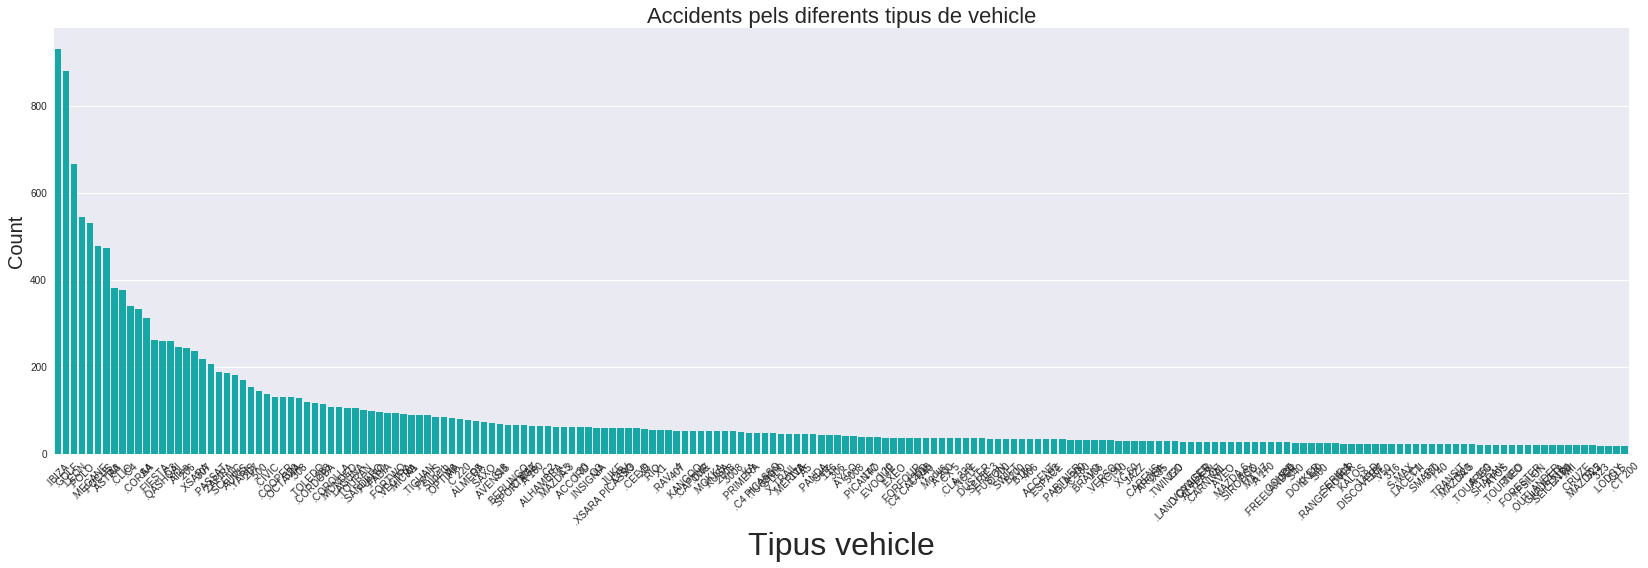

In [11]:
fig, ax = plt.subplots(figsize=(23,8))
ax = sns.countplot(x=accidents_vehicles6["Descripcio_model"], 
                   ax=ax,
                   order = accidents_vehicles6["Descripcio_model"].value_counts().index, color='c' )

plt.xticks(rotation=45)
plt.xlabel('Tipus vehicle', fontsize=32)
plt.ylabel('Count', fontsize=20)
plt.title('Accidents pels diferents tipus de vehicle', fontsize=22)
plt.tight_layout()
plt.show()

In [12]:
accuracy = 0
for brand in accidents_vehicles6['Descripcio_marca'].unique():
    accidents_vehicles7 = accidents_vehicles6[accidents_vehicles6['Descripcio_marca']==brand]
    num_cars= len(accidents_vehicles7)
    print(brand)
    print('Nombre de models de la marca en la sel.lecció: {}'.format(accidents_vehicles7['Descripcio_model'].unique()))
    print('Nombre d\'accidents de cotxes de la marca: {}'.format(num_cars))
    mode = accidents_vehicles7["Descripcio_model"].value_counts().max()
#     tipus_max = accidents_vehicles7["Descripcio_model"].mode()
    relat_freq = mode/num_cars
    print('Percentatge del seu cotxe amb més accidents: {:.2f}% amb {} cotxes.\n'.format(relat_freq*100, mode))
    accuracy = accuracy + relat_freq*num_cars
    
print('### Accuracy d\'agafar la subclasse més comuna és: {:.5f} ### '.format(accuracy/len(accidents_vehicles5)))


AUDI
Nombre de models de la marca en la sel.lecció: ['.A6' '.Q7' '.A1' '.A3' '.A4' '.A5' '.Q5' '.Q3' '.COUPE']
Nombre d'accidents de cotxes de la marca: 1069
Percentatge del seu cotxe amb més accidents: 35.64% amb 381 cotxes.

SMART
Nombre de models de la marca en la sel.lecció: ['.FORTWO' '.SMART' '.FORFOUR']
Nombre d'accidents de cotxes de la marca: 153
Percentatge del seu cotxe amb més accidents: 61.44% amb 94 cotxes.

RENAULT
Nombre de models de la marca en la sel.lecció: ['.CLIO' '.KANGOO' '.MEGANE' '.SCENIC' '.LAGUNA' '.Modus' '.ESPACE'
 '.CAPTUR' '.TWINGO']
Nombre d'accidents de cotxes de la marca: 1398
Percentatge del seu cotxe amb més accidents: 37.98% amb 531 cotxes.

HONDA
Nombre de models de la marca en la sel.lecció: ['.ACCORD' '.CIVIC' '.JAZZ' '.CRV']
Nombre d'accidents de cotxes de la marca: 287
Percentatge del seu cotxe amb més accidents: 48.08% amb 138 cotxes.

SEAT
Nombre de models de la marca en la sel.lecció: ['.Altea' '.IBIZA' '.ALHAMBRA' '.CORDOBA' '.LEON' '.TOLED

In [0]:
# from google.colab import files
# accidents_vehicles_grpby.to_csv("accidents_vehicles_grpby.xsl")
# files.download("accidents_vehicles_grpby.csv")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


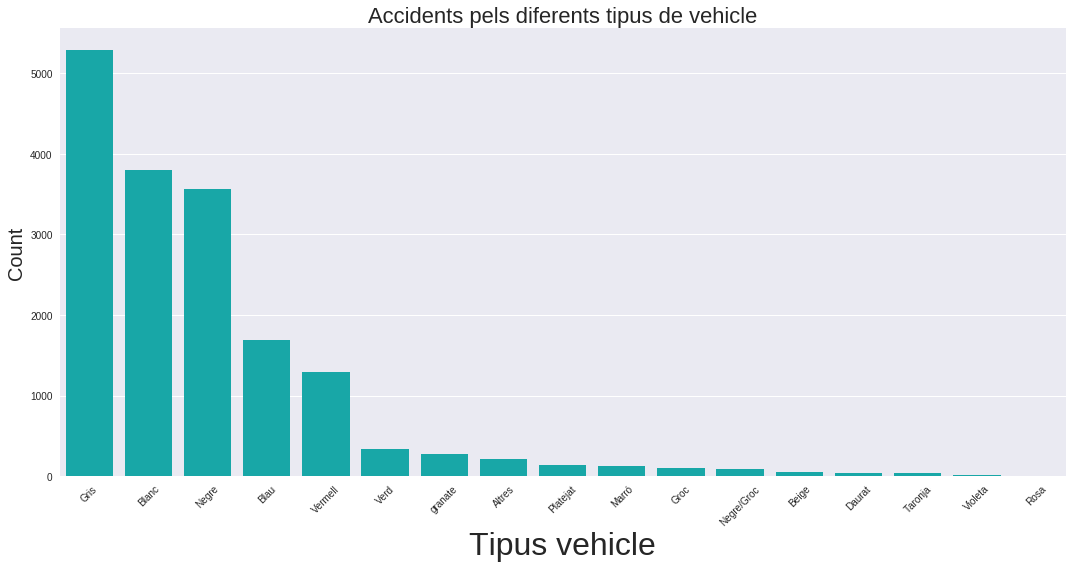

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.countplot(x=accidents_vehicles6["Descripcio_color"], 
                   ax=ax,
                   order = accidents_vehicles6["Descripcio_color"].value_counts().index,
                   color = 'c')

plt.xticks(rotation=45)
plt.xlabel('Tipus vehicle', fontsize=32)
plt.ylabel('Count', fontsize=20)
plt.title('Accidents pels diferents tipus de vehicle', fontsize=22)
plt.tight_layout()
plt.show()

In [0]:
accidents_vehicles6 = pd.concat([accidents_vehicles6, pd.get_dummies(accidents_vehicles6['Descripcio_color'])], axis=1)
accidents_vehicles6 = pd.concat([accidents_vehicles6, pd.get_dummies(accidents_vehicles6['Descripcio_marca'])], axis=1)
accidents_vehicles6 = pd.concat([accidents_vehicles6, pd.get_dummies(accidents_vehicles6['Descripcio_tipus_dia'])], axis=1)
accidents_vehicles6 = pd.concat([accidents_vehicles6, pd.get_dummies(accidents_vehicles6['Descripcio_tipus_vehicle'])], axis=1)
accidents_vehicles6 = pd.concat([accidents_vehicles6, pd.get_dummies(accidents_vehicles6['NK_Any'])], axis=1)
accidents_vehicles6 = pd.concat([accidents_vehicles6, pd.get_dummies(accidents_vehicles6['Num_portes_laterals'])], axis=1)
accidents_vehicles7 = pd.concat([accidents_vehicles6, pd.get_dummies(accidents_vehicles6['Tipus_cotxe'])], axis=1)

In [16]:
# Labels are the values we want to predict
labels_y = pd.get_dummies(accidents_vehicles7['Descripcio_model'] ) 

# Remove the labels from the features
# axis 1 refers to the columns
features_X = accidents_vehicles7.drop(columns = ['Descripcio_color', 'Descripcio_marca', 
                                     'Descripcio_model','Descripcio_tipus_dia', 'NK_Any',
                                     'Descripcio_dia_setmana','Descripcio_tipus_vehicle',
                                     'Num_portes_laterals','Tipus_cotxe'], axis = 1)

features_X

,Codi_barri,Codi_carrer,Codi_districte,Antiguitat_carnet,Dia_mes,Hora_dia,Mes_any,Latitud,Longitud,Altres,Beige,Blanc,Blau,Daurat,...,2016,2017,2018,2,3,4,4x4/SUV,antic/classic,compact,esportiu,familiar,furgoneta,micro,sedan
0,22,202050,5,12,10,19,11,41.4249,2.09232,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,20,700931,4,20,20,10,5,41.3812,2.11892,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,16,701377,3,42,21,12,9,41.3657,2.13454,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,19,320704,4,6,18,3,6,41.3905,2.14244,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,12,701266,3,19,11,12,7,41.3495,2.14683,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
5,8,144601,2,0,24,17,3,41.3933,2.1479,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
6,8,245802,2,17,4,11,1,41.3921,2.15096,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,9,361406,2,46,21,14,10,41.3806,2.15588,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
8,8,32700,2,49,25,12,10,41.3934,2.15702,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
9,9,169409,2,22,8,9,11,41.3821,2.15807,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1


In [17]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(features_X, 
                                                labels_y, 
                                                train_size=0.75, 
                                                random_state = 0
                                               )
 

Xtrain.dtypes

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Codi_barri            int64
Codi_carrer           int64
Codi_districte        int64
Antiguitat_carnet    object
Dia_mes               int64
Hora_dia              int64
Mes_any               int64
Latitud              object
Longitud             object
Altres                uint8
Beige                 uint8
Blanc                 uint8
Blau                  uint8
Daurat                uint8
Gris                  uint8
Groc                  uint8
Marró                 uint8
Negre                 uint8
Negre/Groc            uint8
Platejat              uint8
Rosa                  uint8
Taronja               uint8
Verd                  uint8
Vermell               uint8
Violeta               uint8
granate               uint8
ALFA ROMEO            uint8
AUDI                  uint8
BMW                   uint8
CHEVROLET             uint8
                      ...  
NISSAN                uint8
OPEL                  uint8
PEUGEOT               uint8
RENAULT               uint8
ROVER               

In [18]:
# Feature Scaling
sc = StandardScaler()  
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)  
Xtest = sc.transform(Xtest) 

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [19]:
# get shapes
N, D = Xtrain.shape
K = len(set(ytrain))
print('D:', D, '\nK:',K)

D: 76 
K: 196


In [20]:
# the model will be a sequence of layers
model = Sequential()

model.add(Dense(units=64, input_dim=D))
# model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1024)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=2048)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1024)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=512)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=256)) 
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=K))
model.add(BatchNormalization())
model.add(Activation('softmax'))

from keras.optimizers import SGD
sgd = optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss = "categorical_crossentropy", optimizer = sgd, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4928      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activat

In [21]:
fited_model = model.fit(Xtrain, ytrain, 
                        validation_data=(Xtest, ytest), 
                        epochs=200, 
                        batch_size=2000, 
                       )

Instructions for updating:
Use tf.cast instead.
Train on 12807 samples, validate on 4269 samples
Epoch 1/200
12807/12807 [==============================] - 29s 2ms/step - loss: 5.5544 - acc: 0.0099 - val_loss: 4.1986 - val_acc: 0.2518
Epoch 2/200
12807/12807 [==============================] - 23s 2ms/step - loss: 4.8877 - acc: 0.0515 - val_loss: 3.1751 - val_acc: 0.3525
Epoch 3/200
12807/12807 [==============================] - 12s 963us/step - loss: 4.3420 - acc: 0.1219 - val_loss: 2.7564 - val_acc: 0.4027
Epoch 4/200
12807/12807 [==============================] - 12s 927us/step - loss: 3.9505 - acc: 0.2081 - val_loss: 2.5180 - val_acc: 0.4394
Epoch 5/200
12807/12807 [==============================] - 12s 927us/step - loss: 3.6828 - acc: 0.2776 - val_loss: 2.3372 - val_acc: 0.4638
Epoch 6/200
12807/12807 [==============================] - 12s 971us/step - loss: 3.4385 - acc: 0.3455 - val_loss: 2.1799 - val_acc: 0.4835
Epoch 7/200
12807/12807 [==============================] - 11s 895u

In [22]:
loss, accuracy = model.evaluate(Xtrain, ytrain, verbose=0)
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))
print('')
loss, accuracy = model.evaluate(Xtest, ytest, verbose=0)
print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

Accuracy: 0.644647
Loss: 0.812668

Accuracy: 0.628016
Loss: 0.850649


In [23]:
from sklearn.metrics import classification_report
print(classification_report(ytest,model.predict(Xtest).round()))
# y_pred = model.predict(Xtest)
# confusion_matrix(ytest, y_pred.round())

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       1.00      1.00      1.00         7
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         8
           6       0.64      1.00      0.78         9
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        61
           9       0.00      0.00      0.00        43
          10       0.00      0.00      0.00        24
          11       1.00      1.00      1.00         6
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00        16
          14       1.00      1.00      1.00        13
          15       0.00      0.00      0.00        49
          16       0.47      1.00      0.64        25
          17       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
# from mlxtend.evaluate import confusion_matrix

# y_target = ytest
# y_predicted = model.predict(Xtest).round()

# cm = confusion_matrix(y_target=y_target, 
#                       y_predicted=y_predicted, 
#                       binary=False)
# cm

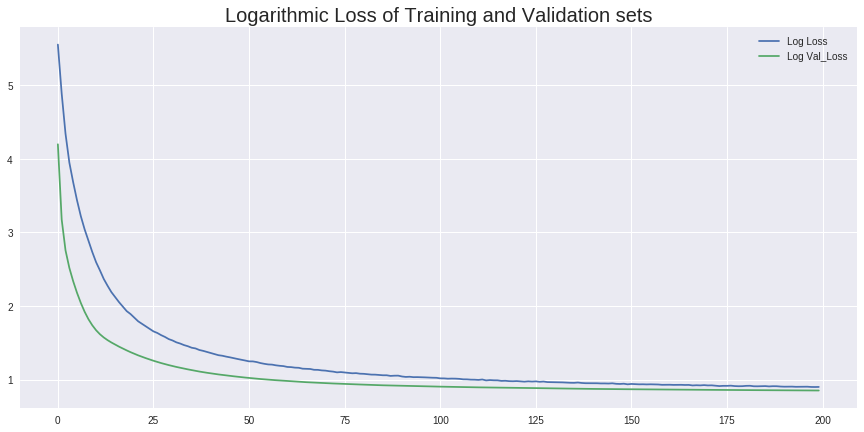

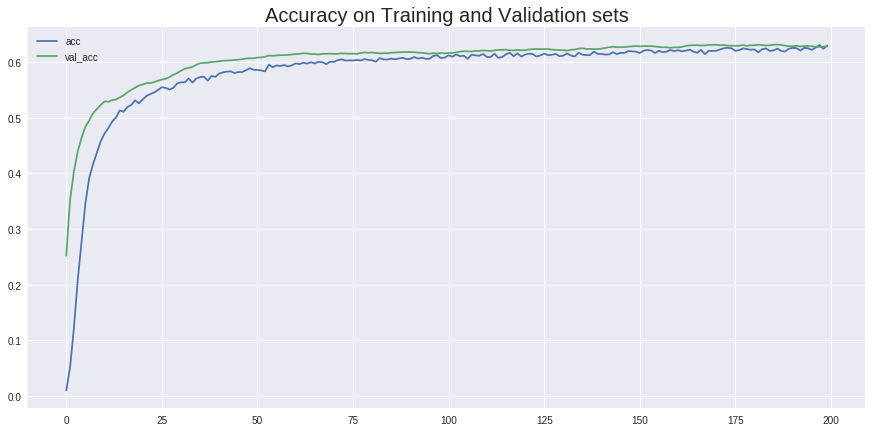

In [24]:
# plot some data
fig = plt.figure(figsize=(15,7))

plt.plot(fited_model.history['loss'], label='Log Loss')
plt.plot(fited_model.history['val_loss'], label='Log Val_Loss')
plt.title('Logarithmic Loss of Training and Validation sets', fontsize=20)

plt.legend()
plt.show()

fig = plt.figure(figsize=(15,7))
plt.plot(fited_model.history['acc'], label='acc')
plt.plot(fited_model.history['val_acc'], label='val_acc')
plt.title('Accuracy on Training and Validation sets', fontsize=20)
plt.legend()
plt.show()

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
dummy = MultiOutputClassifier(DummyClassifier())
dummy.fit(Xtrain, ytrain)
pred_y_d = dummy.predict(Xtest)
print('Dummy Classifier accuracy on the test set: {:.5f}'.format(accuracy_score(ytest,pred_y_d)))

Dummy Classifier accuracy on the test set: 0.00773


# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid =  {
 'max_depth': [200],##FALTA
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
  'n_estimators': [500]
              }

In [0]:
# Random forest
clf_rf = RandomForestClassifier(criterion='gini',
                                random_state=0,
                                n_estimators = 500,
                                max_depth = 150)

clf_rf_grid = GridSearchCV(clf_rf, param_grid, cv=3, n_jobs=-1)

# Train model
model = clf_rf_grid.fit(Xtrain, ytrain)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(ytest,clf_rf_grid.predict(Xtest)))

In [0]:
y_pred = clf_rf_grid.predict(Xtrain) 
y_test_pred = clf_rf_grid.predict(Xtest)

print('Classification accuracy on training set: {:.5f}'.format(accuracy_score(ytrain,y_pred)))
# print('Log Loss on training set: {:.5f}'.format(log_loss(y_train,y_pred)))

print('\nClassification accuracy on test set: {:.5f}'.format(accuracy_score(ytest,y_test_pred))) 
# print('Log Loss on test set: {:.5f}'.format(log_loss(y_test,y_test_pred))) 

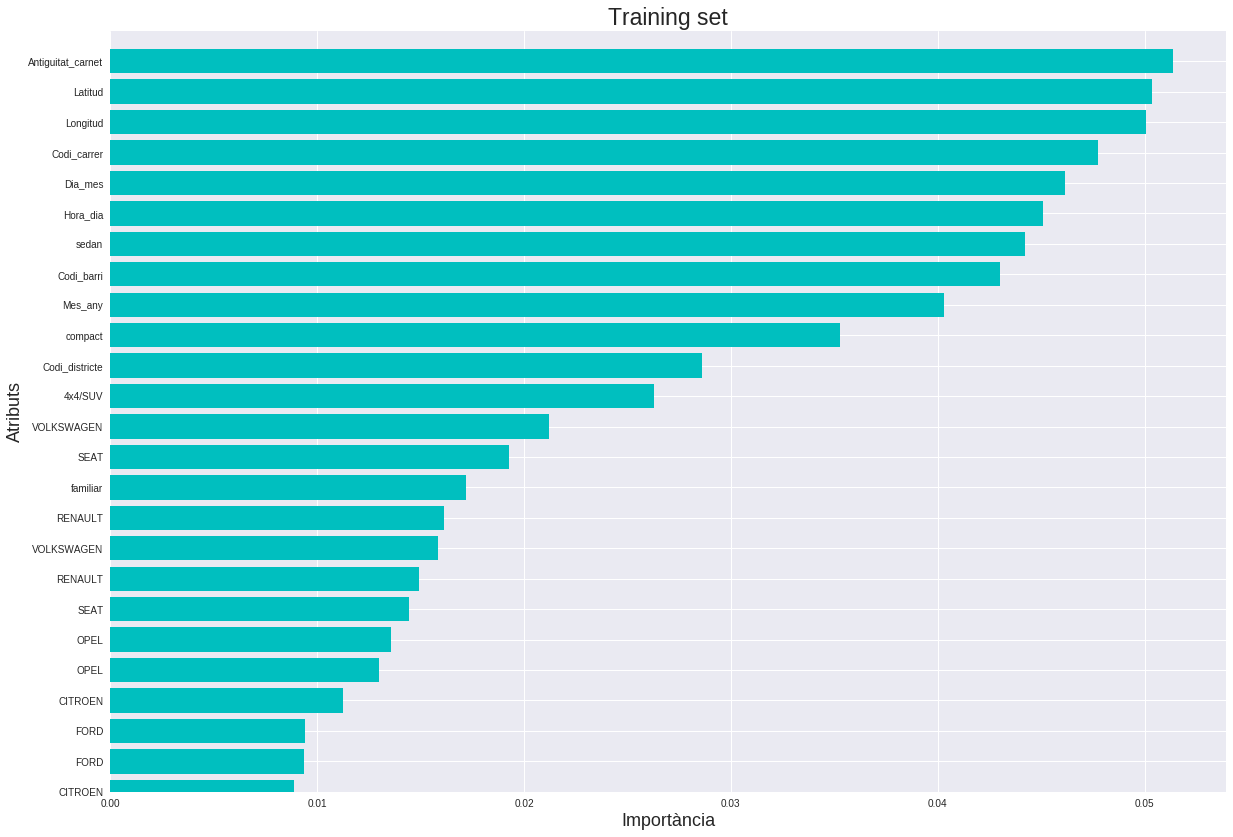

In [74]:
imp = clf_rf_grid.best_estimator_.feature_importances_

names = features_X.columns

imp, names = zip(*sorted(zip(imp, names)))

fig = plt.figure(figsize=(20,14))
ax = fig.gca()

plt.barh(range(len(names)),imp, align = 'center', color='c')
plt.yticks(range(len(names)), names)

ax.set_ylabel('Atributs', size = 18)
ax.set_xlabel('Importància', size = 18)
ax.set_title('Training set', size = 23)


ax.set_ylim([len(names)-25,len(names)])

plt.show()